In [56]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import quandl
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [46]:
start = dt.datetime(1965, 1, 1)
end = dt.datetime(2018, 12, 8)

In [68]:
key = "E8sv_6-yBH6MkRWbfH28"
url = "https://www.quandl.com/api/v3/datasets/OPEC/ORB.csv?api_key="
full_url = url + key

df = quandl.get("EOD/NKE", start_date=start, end_date=end, api_key=os.getenv('QUANDL_API_KEY'))

In [69]:
df = df.reset_index(drop=False)

In [70]:
obs = np.arange(1, len(df) + 1, 1)
df = df.drop(['Volume', 'Dividend', 'Split', 'Adj_Open', 'Adj_High', 'Adj_Low', 'Adj_Close', 'Adj_Volume'], axis=1)
df.head(10)

,Date,Open,High,Low,Close
0,1980-12-02,11.50,11.75,11.50,11.50
1,1980-12-03,11.38,11.38,11.25,11.25
2,1980-12-04,11.62,11.75,11.62,11.62
3,1980-12-05,11.25,11.25,11.00,11.00
4,1980-12-08,10.50,10.50,10.38,10.38
5,1980-12-09,10.38,10.38,10.13,10.13
6,1980-12-10,9.87,9.87,9.50,9.50
7,1980-12-11,9.25,9.25,9.00,9.00
8,1980-12-12,9.38,9.50,9.38,9.38
9,1980-12-15,9.75,9.87,9.75,9.75


In [72]:
OHLC_avg = df.mean(axis = 1)
HLC_avg = df[['High', 'Low', 'Close']].mean(axis = 1)
close_val = df[['Close']]

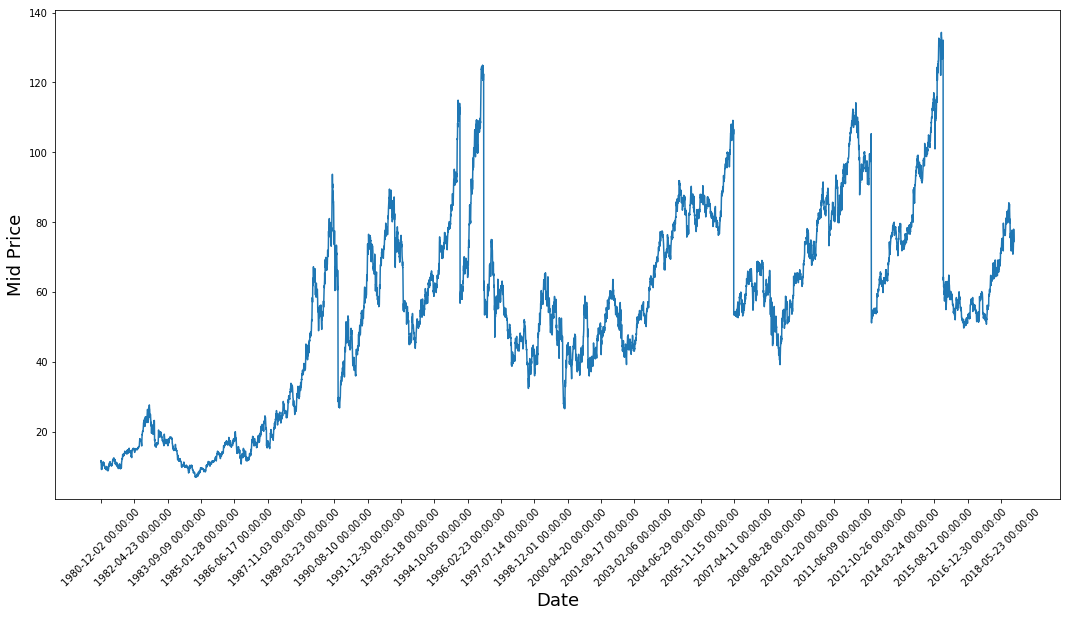

In [73]:
#df.shape[0] = number of rows
increment = 350
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],increment),df['Date'].loc[::increment],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

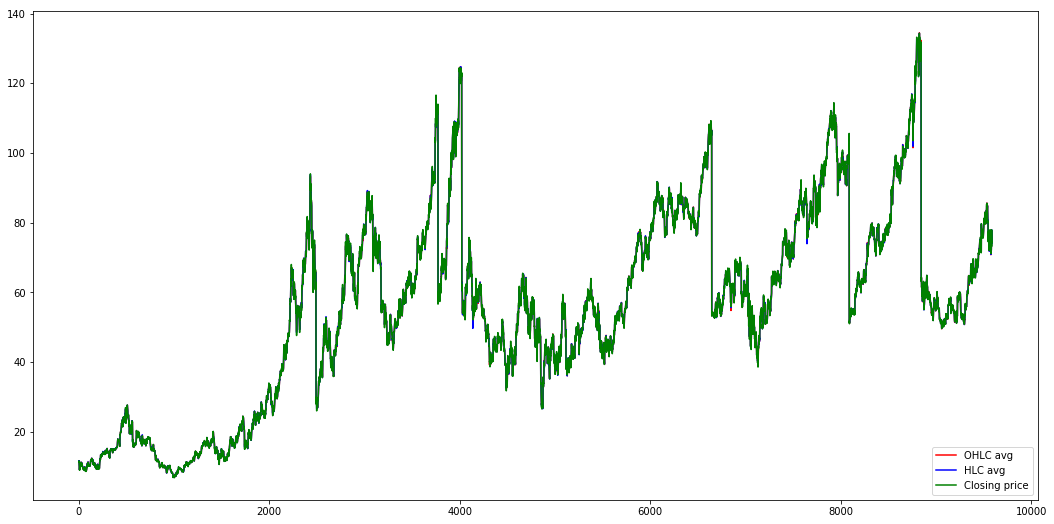

In [76]:
plt.figure(figsize = (18,9))
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'lower right')
plt.show()

In [77]:
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)


In [78]:
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [82]:
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [85]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [90]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adagrad') 
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=1)

Epoch 1/5
7189/7189 [==============================] - 72s 10ms/step - loss: 0.0014
Epoch 2/5
5845/7189 [=======================>......] - ETA: 13s - loss: 1.6833e-04

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])